In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations

import seaborn as sns

<AxesSubplot:>

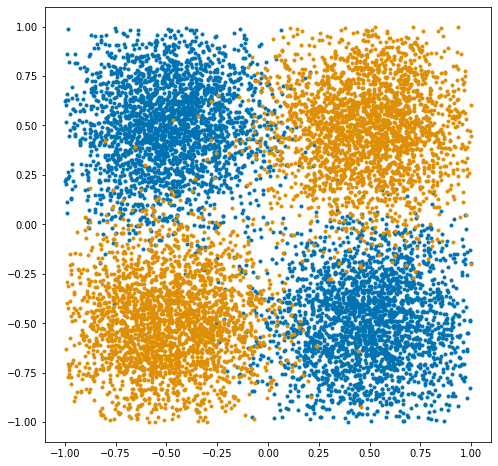

In [2]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

In [3]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [9]:
def getNN(input_size, num_classes, node):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(node, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(node, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(node, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(node, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base


In [10]:
def experiment(nodes):
    X, y = generate_gaussian_parity(10000)
    point_x = np.arange(.5,10,.01)
    point_y = .5*np.ones(950)
    points = np.array([(x,y) for x,y in zip(point_x,point_y)])
    
    nn = getNN(input_size=2, num_classes=2, node=nodes)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)
    
    polytope_ids = model_kdn._get_polytope_ids(points)
    normalizing_factor = np.sum(np.log(model_kdn.network_shape))
    matched_pattern = (polytope_ids==polytope_ids[0])
    matched_nodes = np.zeros((len(polytope_ids),model_kdn.total_layers))
    end_node = 0

    for layer in range(model_kdn.total_layers):
        end_node += model_kdn.network_shape[layer]
        matched_nodes[:, layer] = \
                    np.sum(
                        matched_pattern[:,end_node-model_kdn.network_shape[layer]:end_node], 
                        axis=1
                    )

        scales = np.exp(np.sum(np.log(matched_nodes), axis=1)\
                    - normalizing_factor)
    return scales

In [11]:
nodes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
distance = np.arange(0,9.5,.01)
scales = np.zeros((len(nodes),len(distance)), dtype=float)

for ii,node in enumerate(nodes):
    scales[ii,:] = experiment(node)


2023-01-22 23:19:43.524109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping


2023-01-22 23:20:32.871620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 18: early stopping


2023-01-22 23:21:45.503214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 45: early stopping


2023-01-22 23:23:51.280874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping


2023-01-22 23:26:46.304352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping


2023-01-22 23:30:47.938579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping


2023-01-22 23:35:26.223973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 47: early stopping


2023-01-22 23:41:03.169923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping


2023-01-22 23:47:09.649271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping


2023-01-22 23:54:33.347745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 48: early stopping


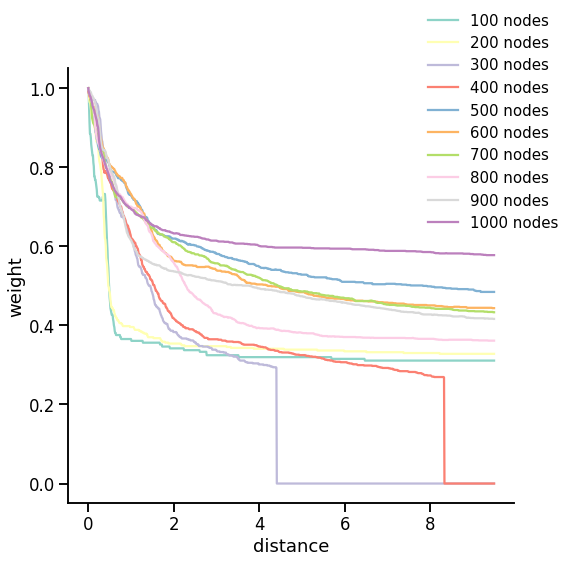

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.set_context('talk')
color = sns.color_palette("Set3", len(nodes))

for ii, node in enumerate(nodes):
    ax.plot(distance, scales[ii,:], c= color[ii], label=str(node)+' nodes')
    
ax.set_xlabel('distance')
ax.set_ylabel('weight')

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

fig.legend(fontsize=15, frameon=False)